**Energy-based Models: Boltzmann Machine**

The energy function of a Fully Visible Boltzmann Machine is described by:

$E(x) = -\frac{1}{2} x^TWx - b^Tx$

where $W$ is a symmetric matrix with zero digonal and $b$ is a bias vector

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FullyVisibleBM(nn.Module):
    def __init__(self, n_visible):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_visible, n_visible) * 0.01)
        # zero-diagonal mask
        self.register_buffer('mask', 1 - torch.eye(n_visible))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def energy(self, v):
        quad = -0.5 * torch.sum((v @ (self.W * self.mask)) * v, dim=1)
        lin  = -torch.matmul(v, self.v_bias)
        return quad + lin

    def cond_prob(self, v, l):
        """Compute P(v_i=1 | v_-i) excluding self-connection."""
        # Masked weights with zero diagonal to prevent self-interaction
        W_masked = self.W * self.mask
        # For symmetric W, W_masked[:, i] == W_masked[i, :]
        # Sum contributions from all other units j != i
        activation = torch.matmul(v, W_masked[:, l])
        return torch.sigmoid(activation)

    def gibbs_sample(self, v0, k=10):
        v = v0.clone()
        for _ in range(k):
            for i in range(v.size(1)):
                p = self.cond_prob(v, i)
                v[:, i] = torch.bernoulli(p)
        return v

# Toy data: 3-bit even parity patterns
data = torch.tensor([[0,0,0],[0,1,1],[1,0,1],[1,1,0]], dtype=torch.float32).to(device)
bm = FullyVisibleBM(n_visible=3).to(device)
opt = torch.optim.SGD(bm.parameters(), lr=0.1)

# Contrastive Divergence (CD-1) training
for epoch in range(1000):
    # Positive phase: compute data expectations
    v_data = data                        # shape [N, D]
    data_mean = v_data.mean(dim=0)       # E_data[v_i]
    # E_data[v_i v_j]: average outer product over the dataset
    data_corr = torch.einsum('nd,ne->de', v_data, v_data) / v_data.size(0)

    # Negative phase: sample from the model to estimate model expectations
    v_model = bm.gibbs_sample(
        torch.bernoulli(torch.full_like(data, 0.5)), k=10
    )  # one-step Gibbs chain
    model_mean = v_model.mean(dim=0)      # E_model[v_i]
    # E_model[v_i v_j]: average outer product over model samples
    model_corr = torch.einsum('nd,ne->de', v_model, v_model) / v_model.size(0)

    # Compute gradients of log-likelihood (data minus model expectations)
    grad_W = data_corr - model_corr      # ∂L/∂W_{ij}
    grad_b = data_mean - model_mean      # ∂L/∂b_i

    # Apply parameter updates (ascent on log-likelihood)
    opt.zero_grad()
    bm.W.grad = -grad_W * bm.mask        # negative for gradient ascent
    bm.v_bias.grad = -grad_b             # negative for gradient ascent
    opt.step()

# Sampling
init = torch.bernoulli(torch.full((10,3),0.5)).to(device)
samples = bm.gibbs_sample(init, k=20)
print("Samples from FV-BM:", samples)

Samples from FV-BM: tensor([[1., 1., 0.],
        [0., 1., 1.],
        [1., 1., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.],
        [0., 1., 0.],
        [1., 0., 1.]], device='cuda:0', grad_fn=<CopySlices>)


Neural-based Energy Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1D data
np.random.seed(0)
data = np.concatenate([np.random.normal(-2,0.5,1000), np.random.normal(2,0.5,1000)])
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1).to(device)

# Neural EBM
class NeuralEBM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128), nn.SiLU(), nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

model = NeuralEBM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Langevin sampler
def langevin_sample(x_init, model, steps, step_size, noise_scale):
    x = x_init.clone().detach().requires_grad_(True)
    for _ in range(steps):
        E = model(x).sum()
        grad = torch.autograd.grad(E, x)[0]
        x = x - step_size * grad + noise_scale * torch.randn_like(x)
        x = x.detach().requires_grad_(True)
    return x.detach()

# Training loop
for epoch in range(20):
    # positive phase
    idx = torch.randint(0, data.size(0), (256,))
    x_pos = data[idx]
    # negative phase: init from noise
    x_neg = torch.randn(256,1, device=device)
    x_neg = langevin_sample(x_neg, model, steps=2, step_size=0.1, noise_scale=0.01)

    E_pos = model(x_pos).mean()
    E_neg = model(x_neg).mean()
    # loss = E_data - E_model; note this can be negative if E_model > E_data
    loss = E_pos - E_neg

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 500 == 0:
        # print both energies and the loss; loss negative means model samples have lower energy
        print(f"Epoch {epoch}, E_data {E_pos.item():.4f}, E_model {E_neg.item():.4f}, loss {loss.item():.4f}")

# Visualize learned density via exp(-E(x)) via exp(-E(x))
xs = torch.linspace(-5,5,10000).unsqueeze(1).to(device)
E = model(xs).detach().cpu().numpy().flatten()
density = np.exp(-E)
density /= density.mean() # arbitrary normalization

plt.figure()
plt.hist(data.cpu().numpy(), bins=50, density=True, alpha=0.3)
plt.plot(xs.cpu().numpy(), density)
plt.title("Learned density vs data histogram")
plt.show()

Epoch 0, E_data 0.1097, E_model -0.1257, loss 0.2354


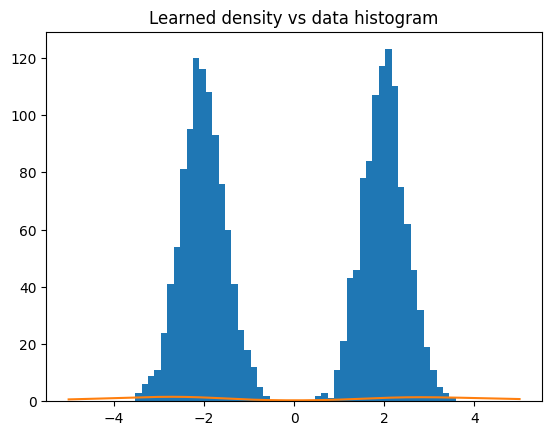

In [ ]:
plt.figure()
plt.hist(data.cpu().numpy(), bins=50, density=True, alpha=1)
plt.plot(xs.cpu().numpy(), density)
plt.title("Learned density vs data histogram")
plt.show()